# Bayesian Regression

In [1]:
import torch
import numpy as np
import pyro
import pyro.distributions as dist

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

/Users/fahad/miniconda3/envs/BML/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Pyro introduction

In [7]:
# With Pyro, we will start working with distributions
# List of base distirbutions: https://docs.pyro.ai/en/dev/distributions.html

# Example MVN([1,2,3], I(3))
d_mvn = dist.MultivariateNormal(torch.tensor([1.,2.,3.]), torch.eye(3))
print(d_mvn)

# draw 100 samples
mvn_sample = d_mvn.sample([100])

print("\n=== One MVN ===")
print("Event shape:", d_mvn.event_shape)
print("Sample shape:", mvn_sample.shape)
print("Sample mean:", mvn_sample.mean(0))

MultivariateNormal(loc: torch.Size([3]), covariance_matrix: torch.Size([3, 3]))

=== One MVN ===
Event shape: torch.Size([3])
Sample shape: torch.Size([100, 3])
Sample mean: tensor([1.0414, 2.0260, 2.9476])


In [8]:
# We can also duplicate distributions, to have several independent draws
# here we say that each batch will draw from 2 identical MVN distribution
d_two_mvn = dist.MultivariateNormal(torch.tensor([1.,2.,3.]), torch.eye(3)).expand([2])
print(d_two_mvn)
two_mvn_sample = d_two_mvn.sample([100])

print("\n=== Two MVN ===")
print("Batch shape:", d_two_mvn.batch_shape, "(Number of distributions from the same family)")
print("Event shape:", d_two_mvn.event_shape, "(Each distribution has a draw of this shape)")
print("Sample shape:", two_mvn_sample.shape)
print("Sample mean:\n", two_mvn_sample.mean(0))

MultivariateNormal(loc: torch.Size([2, 3]), covariance_matrix: torch.Size([2, 3, 3]))

=== Two MVN ===
Batch shape: torch.Size([2]) (Number of distributions from the same family)
Event shape: torch.Size([3]) (Each distribution has a draw of this shape)
Sample shape: torch.Size([100, 2, 3])
Sample mean:
 tensor([[0.9620, 2.0027, 2.9934],
        [0.9450, 2.0466, 2.9341]])


In [16]:
# Sometimes we want to group independent distribtuions to pretend it's a single joint distribution
# we can use to_event(N dim to join), and the last N dimensions will be grouped
d_bernouilli = dist.Bernoulli(0.5 * torch.ones(3,4)).to_event(1)
print(d_bernouilli)
bernouilli_sample = d_bernouilli.sample([100])
print("\n=== 3 x MultiBernouilli(dim=4,p=0.5) ===")
print("Batch shape:", d_bernouilli.batch_shape, "(Number of distributions from the same family)")
print("Event shape:", d_bernouilli.event_shape, "(Each distribution has a draw of this shape)")
print("Sample shape:", bernouilli_sample.shape)
print("Sample mean:\n", bernouilli_sample.mean(0))

Independent(Bernoulli(probs: torch.Size([3, 4])), 1)

=== 3 x MultiBernouilli(dim=4,p=0.5) ===
Batch shape: torch.Size([3]) (Number of distributions from the same family)
Event shape: torch.Size([4]) (Each distribution has a draw of this shape)
Sample shape: torch.Size([100, 3, 4])
Sample mean:
 tensor([[0.5100, 0.5700, 0.4800, 0.4800],
        [0.5700, 0.5400, 0.5100, 0.5600],
        [0.5600, 0.4600, 0.5100, 0.5100]])


In [17]:
# Sometimes we want to create unique distributions
# Defining a plate will draw independent samples of the distribution inside
# The rightmost batch dimension will be used. If it's not there, it will be created.
# Samples should be named
# imagine the plate acting like a for loop
with pyro.plate("gambles", 100):
    # probability of winning = 0.3
    win_draw = pyro.sample("win", dist.Bernoulli(0.3))
    # betted sum
    betted_sum = pyro.sample("bet", dist.Poisson(10))
    # outcome
    outcome_sample = win_draw * 2 * betted_sum

print("\n=== Sample of betting outcomes ===")
print("Sample shape:", outcome_sample.shape)
print("Sample mean:\n", outcome_sample.mean(0))


=== Sample of betting outcomes ===
Sample shape: torch.Size([100])
Sample mean:
 tensor(5.9600)



=== Sample of sales(day) ===
Sample shape: torch.Size([100])
Sample mean:
 tensor(105.7764)


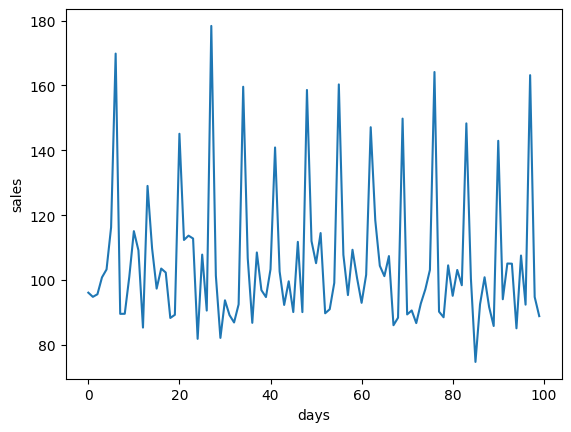

In [18]:
# you can also vary some factor accross draws
# here "day" will be like a numpy arange(100)
# we want to draw "sales" from a distribution with a higher mean on sundays 
with pyro.plate("days", 100) as day:
    is_sunday = (day+1) % 7 == 0
    sales_amount = pyro.sample("sales", dist.Gamma(100.+ is_sunday * 50.,1.))

print("\n=== Sample of sales(day) ===")
print("Sample shape:", sales_amount.shape)
print("Sample mean:\n", sales_amount.mean(0))

plt.plot(sales_amount)
plt.xlabel("days")
plt.ylabel("sales")
plt.show()


=== Sample of sales(product,day) ===
Sample shape: torch.Size([20, 100])
Sample mean:
 tensor([100.1354, 100.0145, 102.3801, 103.0066,  97.4189,  96.8041, 145.4943,
         99.8168,  98.1971, 100.1390,  97.0620, 104.6759, 101.1019, 151.4674,
        101.9972,  98.7030,  98.0761, 100.7221,  99.5168,  97.6260, 148.9387,
         96.2074, 104.9856, 102.5637, 101.0925,  99.0839, 100.1828, 151.3518,
         99.1395, 100.8600, 101.3501, 107.1956,  95.3148,  96.5577, 149.3460,
        101.6924,  95.9103, 100.2298,  99.4451, 100.1228, 100.9923, 151.7302,
         96.3561, 102.6105,  98.8151,  96.6164, 102.5445,  96.8234, 145.8788,
        103.9644, 102.6896,  99.0059,  97.9153,  97.9163,  97.6224, 149.1391,
        100.0080, 100.8222, 100.3286, 104.6476,  99.3599, 103.9920, 150.4087,
         98.8205, 102.7024,  92.7886,  98.3861, 100.4204,  98.5862, 155.1980,
        100.0089,  98.7584, 102.0679, 101.7244, 102.3551,  98.7868, 152.5372,
        100.0859, 100.5834, 102.0071, 101.2908,  96.52

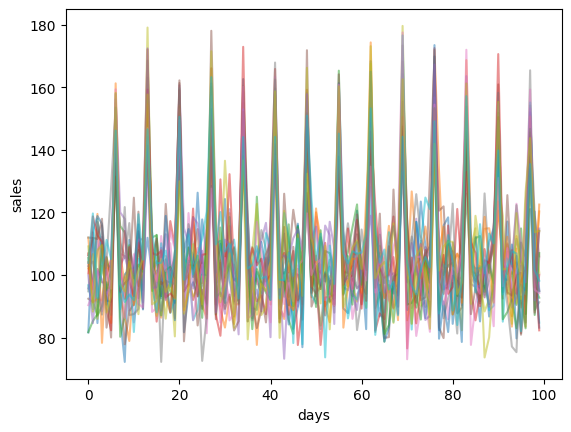

In [19]:
# you can also use several plates
with  pyro.plate("products", 20, dim=-2):
    with pyro.plate("days", 100) as day:
        is_sunday = (day+1) % 7 == 0
        sales_amount = pyro.sample("sales", dist.Gamma(100.+ is_sunday * 50.,1.))

print("\n=== Sample of sales(product,day) ===")
print("Sample shape:", sales_amount.shape)
print("Sample mean:\n", sales_amount.mean(0))

plt.plot(sales_amount.transpose(-1,-2), alpha=0.5)
plt.xlabel("days")
plt.ylabel("sales")
plt.show()

## Generating the data

In [3]:
# Generate data
N = 100

torch.manual_seed(0)

# True model: E[y] = 5 + 1.0 * x_1 - 0.2 * x_2
# y ~ N(E[y], 0.5)
const = 5.
coefs = torch.tensor([1., -0.2])
sigma = 0.5


X = torch.stack( [ torch.normal(mean=1.,std=0.5,size=(N,)),
                   torch.normal(mean=10.,std=5.,size=(N,))
                  ], dim = 1)


y_mean = const + torch.sum(X * coefs, dim=1)
y = torch.normal(mean=y_mean,std=sigma)


print("X means: ", X.mean(0))
print("X std: ", X.std(0))

print("Y mean: ", y.mean())     # theoretically, 5 + 1 - 2 = 4
print("Y std: ", y.std())       # theoretically, np.sqrt(0.5 ** 2 + 1.0 ** 2) = 1.118

X means:  tensor([ 1.0186, 10.7763])
X std:  tensor([0.5148, 4.6360])
Y mean:  tensor(3.8337)
Y std:  tensor(1.3646)


## Defining our Bayesian model

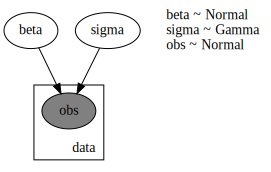

In [4]:
# Simple linear model
# a model is a stochastic function.
def simple_model(X, y=None):
    coefs = pyro.sample("beta", dist.Normal(0., 1.).expand([3]).to_event(1))
    sigma = pyro.sample("sigma", dist.Gamma(1.,1.))

    E_y = coefs[0] + torch.sum(coefs[1:] * X, dim=1)

    with pyro.plate("data", X.shape[0]):
        return pyro.sample("obs", dist.Normal(E_y, sigma), obs=y)

pyro.render_model(simple_model, model_args=(X,y), render_distributions=True)

## SVI using autoguide

Elbo loss: 1119.0076571069658
Elbo loss: 213.98480081558228
Elbo loss: 205.46257829666138
Elbo loss: 190.58660435676575
Elbo loss: 164.57971560955048
Elbo loss: 151.73213848099113
Elbo loss: 135.38049023598433
Elbo loss: 141.205932199955
Elbo loss: 111.69311860203743
Elbo loss: 120.02249929308891


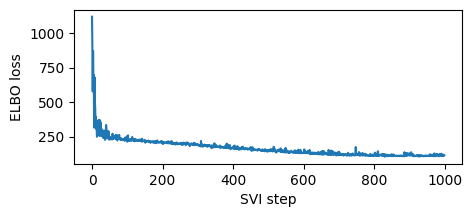

Variational distributions estimates and plots
AutoNormal.locs.beta [ 4.873962    1.1748301  -0.21258797]
AutoNormal.scales.beta [0.05720003 0.04848261 0.00682623]
AutoNormal.locs.sigma -0.5227465
AutoNormal.scales.sigma 0.07794269


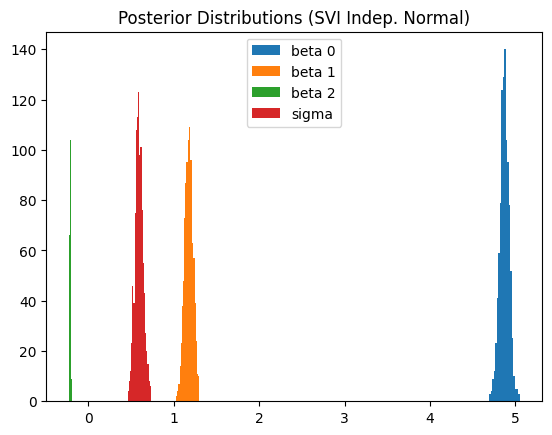

In [6]:
# Stochastic Variational approach
# The posterior distributions are parametric, and we just estimate their parameters
import logging

auto_guide = pyro.infer.autoguide.AutoNormal(simple_model)

pyro.clear_param_store()

# These should be reset each training loop.
adam = pyro.optim.Adam({"lr": 0.02})  # Consider decreasing learning rate.
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(simple_model, auto_guide, adam, elbo)

losses = []
for step in range(1000):  # Consider running for more steps.
    loss = svi.step(X, y)
    losses.append(loss)
    if step % 100 == 0:
        print("Elbo loss: {}".format(loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss")
plt.show()

# Show results
print("Variational distributions estimates and plots")
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())


#we sample from our trained variational dist
with pyro.plate("samples", 1000, dim=-1):
    var_samples = auto_guide(X)

# plot results
for ii in range(var_samples['beta'].shape[-1]):
    plt.hist(var_samples['beta'][:,ii].detach().cpu().numpy(), bins=20, label="beta %d" %ii)
plt.hist(var_samples['sigma'].detach().cpu().numpy(), bins=20, label="sigma")
plt.title("Posterior Distributions (SVI Indep. Normal)")
plt.legend(loc="upper center")
plt.show()

## SVI using custom guide

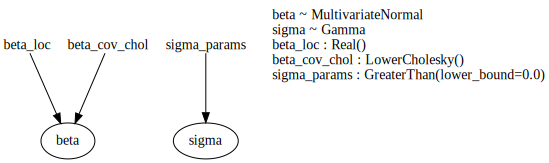

In [21]:
# Stochastic variational inference with custom variational distribution
# We will allow for correlation between the betas, and for sigma to be positive

def custom_guide(X, y=None):
    # parameter of the distributions we want to estimate
    mvn_loc = pyro.param('beta_loc', torch.tensor([0.,0.,0.]))
    mvn_cov_chol = pyro.param('beta_cov_chol', torch.eye(3), constraint=dist.constraints.lower_cholesky)
    
    sigma_params = pyro.param('sigma_params', torch.tensor([1.,1.]), constraint=dist.constraints.positive)

    # corresponding distributions
    beta = pyro.sample("beta",dist.MultivariateNormal( mvn_loc, scale_tril =mvn_cov_chol))
    sigma = pyro.sample("sigma", dist.Gamma(sigma_params[0],sigma_params[1]))
    
    # Variational Model
    return {"beta": beta, "sigma": sigma}
    
pyro.render_model(custom_guide, model_args=(X,y), render_distributions=True, render_params=True, render_deterministic=True)

Elbo loss: 19925.39453125
Elbo loss: 447.6342771053314
Elbo loss: 403.0774338245392
Elbo loss: 1144.0960264205933
Elbo loss: 841.7073438167572
Elbo loss: 318.22793531417847
Elbo loss: 277.11604595184326
Elbo loss: 297.21713972091675
Elbo loss: 320.80655217170715
Elbo loss: 378.79639863967896
Elbo loss: 320.52732145786285
Elbo loss: 564.49156665802
Elbo loss: 375.1542637348175
Elbo loss: 326.73584043979645
Elbo loss: 411.2984387874603
Elbo loss: 325.99025321006775
Elbo loss: 342.0507574081421
Elbo loss: 345.3835446834564
Elbo loss: 389.3253104686737
Elbo loss: 424.4173729419708
Elbo loss: 349.2755048274994
Elbo loss: 392.4033203125
Elbo loss: 275.3119740486145
Elbo loss: 344.9855878353119
Elbo loss: 328.3482360839844
Elbo loss: 312.34293127059937
Elbo loss: 336.46091175079346
Elbo loss: 205.14521884918213
Elbo loss: 354.7852144241333
Elbo loss: 293.1877965927124
Elbo loss: 239.8179875612259
Elbo loss: 247.97420501708984
Elbo loss: 519.6713147163391
Elbo loss: 380.40104269981384
Elbo los

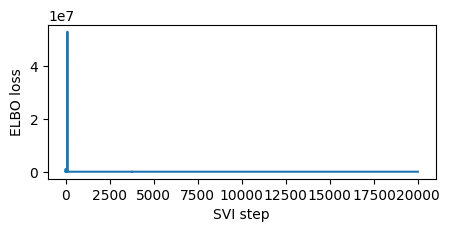

In [22]:
# Stochastic Variational approach with custom guide

pyro.clear_param_store()

# These should be reset each training loop.
adam = pyro.optim.Adam({"lr": 0.05})  # Consider decreasing learning rate.
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(simple_model, custom_guide, adam, elbo)

losses = []
for step in range(20000):  # Consider running for more steps.
    loss = svi.step(X, y)
    losses.append(loss)
    if step % 500 == 0:
        print("Elbo loss: {}".format(loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss")
plt.show()

Variational distributions estimates
beta_loc [ 4.4870477  1.303539  -0.2092933]
beta_cov_chol [[ 0.30423993  0.          0.        ]
 [-0.09812615  0.15760487  0.        ]
 [-0.00597156 -0.01137531  0.01381641]]
sigma_params [10.9336815 11.802747 ]
beta cov: tensor([[ 0.0926, -0.0299, -0.0018],
        [-0.0299,  0.0345, -0.0012],
        [-0.0018, -0.0012,  0.0004]], grad_fn=<MmBackward0>)


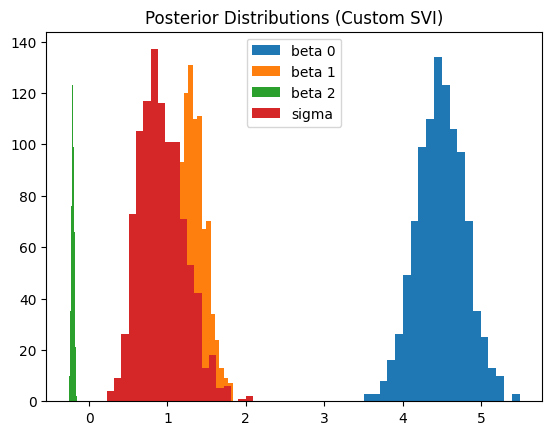

In [26]:
print("Variational distributions estimates")
custom_params = {}
for name, value in pyro.get_param_store().items():
    custom_params[name] = value
    print(name, pyro.param(name).data.cpu().numpy())   
print("beta cov:", custom_params["beta_cov_chol"] @ custom_params["beta_cov_chol"].mT)

# Draw sample from posterior and plot results
with pyro.plate("samples", 1000, dim=-1):
    custom_var_samples = custom_guide(X)
    
# plot results
for ii in range(custom_var_samples['beta'].shape[-1]):
    plt.hist(custom_var_samples['beta'][:,ii].detach().cpu().numpy(), bins=20, label="beta %d" %ii)
plt.hist(custom_var_samples['sigma'].detach().cpu().numpy(), bins=20, label="sigma")
plt.title("Posterior Distributions (Custom SVI)")
plt.legend(loc="upper center")
plt.show()

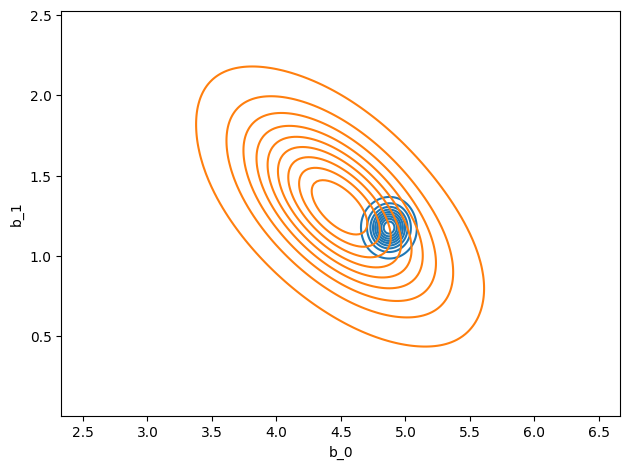

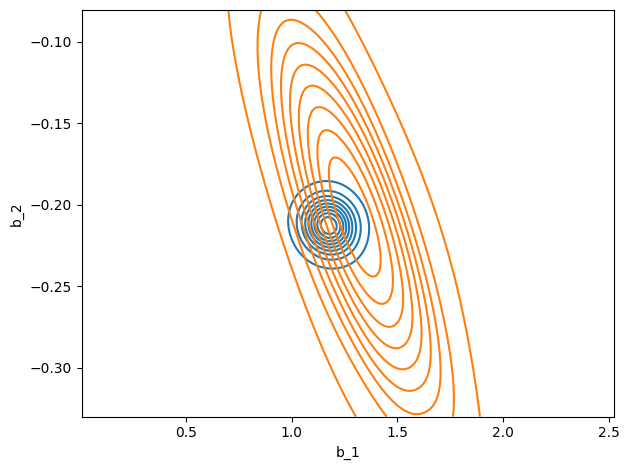

In [27]:
# compare the posterior dist for beta


beta_post_samples_auto = var_samples["beta"].detach().cpu().numpy()
beta_post_samples_custom = custom_var_samples["beta"].detach().cpu().numpy()



sns.kdeplot(x=beta_post_samples_auto[:,0], y=beta_post_samples_auto[:,1], bw_adjust=4 , label="Indep. Normal")
sns.kdeplot(x=beta_post_samples_custom[:,0], y=beta_post_samples_custom[:,1], bw_adjust=4 , label="Multi. Normal")
plt.xlabel("b_0")
plt.ylabel("b_1")
plt.tight_layout()
plt.show()


sns.kdeplot(x=beta_post_samples_auto[:,1], y=beta_post_samples_auto[:,2], bw_adjust=4 , label="Indep. Normal")
sns.kdeplot(x=beta_post_samples_custom[:,1], y=beta_post_samples_custom[:,2], bw_adjust=4 , label="Multi. Normal")
plt.xlabel("b_1")
plt.ylabel("b_2")
plt.tight_layout()
plt.show()

## MCMC estimation

Sample: 100%|██████████| 1200/1200 [00:15, 77.37it/s, step size=1.48e-01, acc. prob=0.956]


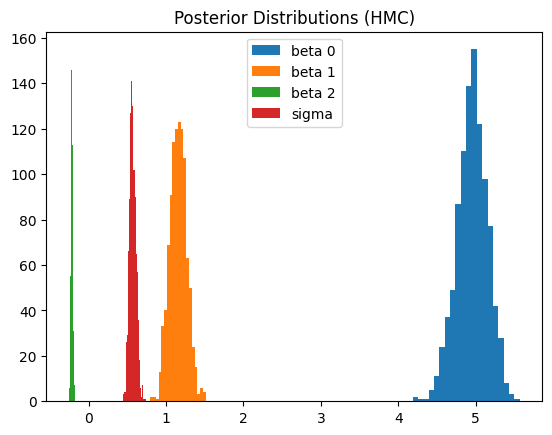

In [28]:
# MCMC estimation
from pyro.infer import MCMC, NUTS


nuts_kernel = NUTS(simple_model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)
mcmc.run(X, y)
hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}


# plot results
for ii in range(hmc_samples['beta'].shape[-1]):
    plt.hist(hmc_samples['beta'][:,ii], bins=20, label="beta %d" %ii)
plt.hist(hmc_samples['sigma'], bins=20, label="sigma")
plt.title("Posterior Distributions (HMC)")
plt.legend(loc="upper center")
plt.show()

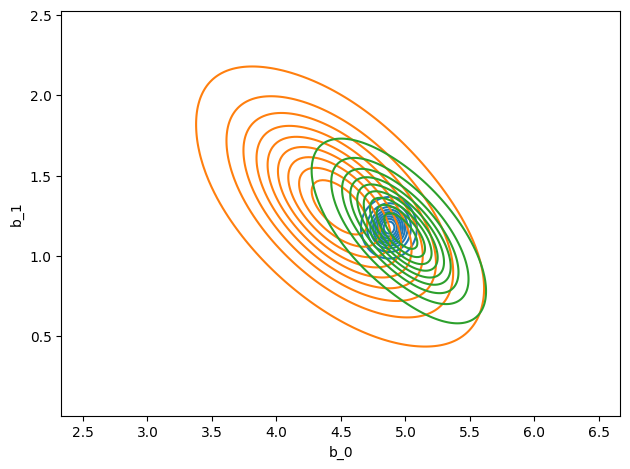

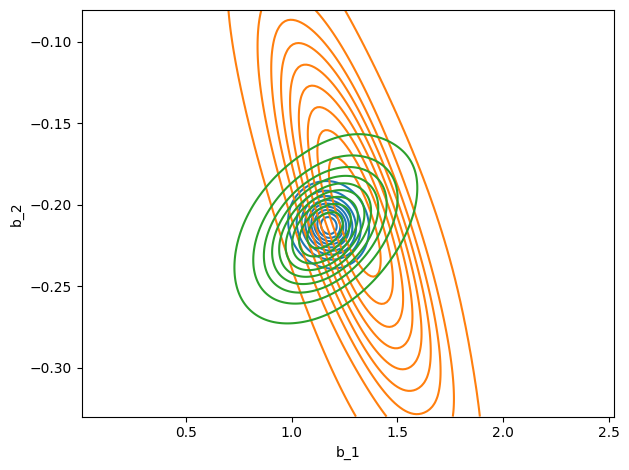

Predictive sample shape: torch.Size([1000, 100])
Observed y for X[0]: 2.148
Quartiles from predictive y given X[0]: 1.87 / 2.23 / 2.62


/var/folders/_2/rx7m09f91v7gt9zg_fctgksr0000gn/T/ipykernel_6675/4126506029.py:36: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(mvn_predictive_samples["obs"][:,0], label="Predictive")


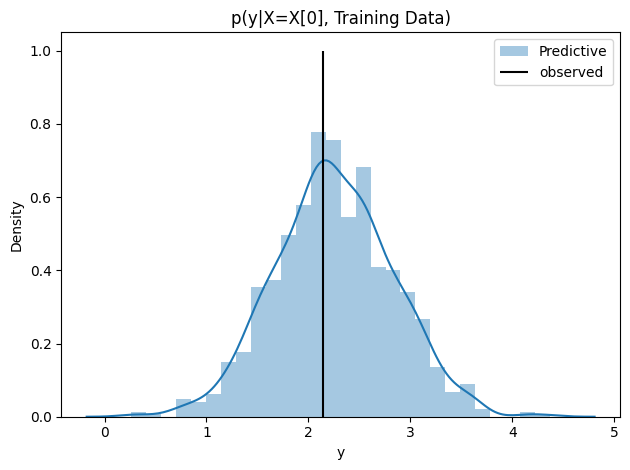

In [29]:
# compare the posterior dist for beta


beta_post_samples_auto = var_samples["beta"].detach().cpu().numpy()
beta_post_samples_custom = custom_var_samples["beta"].detach().cpu().numpy()
beta_post_samples_hmc = hmc_samples["beta"]



sns.kdeplot(x=beta_post_samples_auto[:,0], y=beta_post_samples_auto[:,1], bw_adjust=4 , label="Indep. Normal")
sns.kdeplot(x=beta_post_samples_custom[:,0], y=beta_post_samples_custom[:,1], bw_adjust=4 , label="Multi. Normal")
sns.kdeplot(x=beta_post_samples_hmc[:,0], y=beta_post_samples_hmc[:,1], bw_adjust=4 , label="Multi. Normal")
plt.xlabel("b_0")
plt.ylabel("b_1")
plt.tight_layout()
plt.show()


sns.kdeplot(x=beta_post_samples_auto[:,1], y=beta_post_samples_auto[:,2], bw_adjust=4 , label="Indep. Normal")
sns.kdeplot(x=beta_post_samples_custom[:,1], y=beta_post_samples_custom[:,2], bw_adjust=4 , label="Multi. Normal")
sns.kdeplot(x=beta_post_samples_hmc[:,1], y=beta_post_samples_hmc[:,2], bw_adjust=4 , label="Multi. Normal")
plt.xlabel("b_1")
plt.ylabel("b_2")
plt.tight_layout()
plt.show()


# draw from predictive distribution
mvn_predictive = pyro.infer.Predictive(simple_model, posterior_samples=mcmc.get_samples())
mvn_predictive_samples = mvn_predictive(X, y=None)

print("Predictive sample shape:",mvn_predictive_samples["obs"].shape)
print("Observed y for X[0]: %.3f" % y[0])
print("Quartiles from predictive y given X[0]: %.2f / %.2f / %.2f" % tuple(np.quantile(mvn_predictive_samples["obs"][:,0],[0.25,0.5,0.75])) )

sns.distplot(mvn_predictive_samples["obs"][:,0], label="Predictive")
plt.vlines(y[0],0,1, label="observed", color="k")
plt.xlabel("y")
plt.title("p(y|X=X[0], Training Data)")
plt.legend()
plt.tight_layout()
plt.show()